In [1]:
#!pip install transformers
import json
import pandas as pd
import numpy as np
import re
import seaborn as sns
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score, roc_curve, auc, roc_auc_score
import pickle
from heapq import nlargest
from scipy.special import softmax
from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

Using TensorFlow backend.


In [2]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU Available: True
Number of GPU Available: 4
GPU: Tesla V100-SXM2-32GB


In [3]:
#df = pd.read_pickle("../data/fd_vn_physical_with_tokens_and_pooled_output_v5.pkl")

#df = pd.read_csv('/nfs/research/regan/src/coling2020-code/data/augmented_with_ccs_rq13_v3.csv')

df = pd.read_csv('/nfs/research/regan/src/coling2020-code/data/augmented_with_ccs_rq21_v5.csv')

df.cc = df.cc.apply(literal_eval)

In [4]:
df.head()

,pk,cc,sentence,syntax,fd1,fd2,fd3,verb,augmented,dep,silver_cc,gold_cc
0,664.0,"[{'text': 'cart', 'q_value': 'INTL', 'index': ...",The grocery cart hit against the wall,Sbj V PathP,Physical,Force,none,hit,0,"[{'text': 'The', 'dep': 'det'}, {'text': 'groc...",cart wall,cart wall
1,665.0,"[{'text': 'rope', 'q_value': '+MER', 'index': ...",That type of rope coiled easily around the post,Sbj V PathP,Autonomous,Place,none,coil,0,"[{'text': 'That', 'dep': 'det'}, {'text': 'typ...",rope post,rope post
2,666.0,"[{'text': 'rope', 'q_value': '+MER', 'index': ...",The rope coiled around the post,Sbj V PathP,Autonomous,Place,none,coil,0,"[{'text': 'The', 'dep': 'det'}, {'text': 'rope...",rope post,rope post
3,667.0,"[{'text': 'company', 'q_value': '+MER', 'index...",The company is wedging into new markets,Sbj V PathP,Autonomous,Place,none,wedge,0,"[{'text': 'The', 'dep': 'det'}, {'text': 'comp...",company markets,company markets
4,669.0,"[{'text': 'computer', 'q_value': '+MER', 'inde...",The computer connected well to the network,Sbj V PathP,Autonomous,Place,none,connect,0,"[{'text': 'The', 'dep': 'det'}, {'text': 'comp...",computer network,computer network


In [5]:
df.iloc[0].cc

[{'text': 'cart',
  'q_value': 'INTL',
  'index': 3,
  'dep': 'nsubj',
  'fd_subsequent': 7,
  'fd_relation': 'FRC'},
 {'text': 'wall',
  'q_value': 'EXIST',
  'index': 7,
  'dep': 'nmod',
  'fd_subsequent': -1,
  'fd_relation': 'None'}]

In [6]:
len(df)

2137

In [7]:
def get_all_unique_q_values(df):
    all_q_values = []
    all_ccs = df.cc
    for cc in all_ccs:
        for token_bundle in cc:
            q_value = token_bundle["q_value"]
            if q_value == "DES**INTL":
                q_value = "INTL"
            if q_value == "":
                q_value = "MOT"
            if q_value == "MPROP" or q_value=="PROP":
                q_value = "COS"
            if q_value not in all_q_values:
                all_q_values.append(q_value)
                
    return sorted(all_q_values)
    
    
all_q_values = get_all_unique_q_values(df)
all_q_values

['+MER',
 '-MER',
 'COS',
 'DES',
 'EXIST',
 'INTL',
 'MOT',
 'VOL',
 'VOL::+MER',
 'VOL::COS',
 'VOL::INTL',
 'VOL::MOT']

In [8]:
def make_df_for_train(df, augmented=True):

    all_items = []
    
    if not augmented:
        dff = df[df['augmented']==0]
    else:
        dff = df.copy(deep=True)

    for idx, row in dff.iterrows(): 

        cc = row.cc

        for c in cc:
            entity = c["text"] 
            sentence = row.sentence
            #sentence = sentence + " [SEP] " + entity + " [SEP] [CLS]"

            #sentence = sentence + " [SEP] " + entity + " [EOS] "
            
            # sentence = sentence + " [SEP] " + entity
            
            sentence = "<s> " + sentence + " </s> </s> " + entity + " </s>"
            
            prop = c['q_value']
            if prop == 'PROP':
                prop = 'COS'

            item = {"sentence":sentence,'+MER': 0, '-MER':0, 'COS':0, 'DES':0, 'EXIST':0, 
                                        'INTL':0, 'MOT':0, 'VOL': 0, 'property': prop}

            q_value = c["q_value"]

            if q_value == "":
                item["MOT"] = 1
            elif "**" in q_value:
                item["INTL"] = 1
            elif "MPROP" in q_value or "PROP" in q_value:
                item["COS"] = 1
            elif "::" in q_value:
                q_values = c["q_value"].split("::")
                for q in q_values:
                    item[q] = 1
            else:
                item[q_value] = 1
            all_items.append(item)
    
    return pd.DataFrame(all_items)

df1 = make_df_for_train(df, augmented=True)

In [9]:
df1.iloc[0:10]

,sentence,+MER,-MER,COS,DES,EXIST,INTL,MOT,VOL,property
0,<s> The grocery cart hit against the wall </s>...,0,0,0,0,0,1,0,0,INTL
1,<s> The grocery cart hit against the wall </s>...,0,0,0,0,1,0,0,0,EXIST
2,<s> That type of rope coiled easily around the...,1,0,0,0,0,0,0,0,+MER
3,<s> That type of rope coiled easily around the...,0,0,0,0,1,0,0,0,EXIST
4,<s> The rope coiled around the post </s> </s> ...,1,0,0,0,0,0,0,0,+MER
5,<s> The rope coiled around the post </s> </s> ...,0,0,0,0,1,0,0,0,EXIST
6,<s> The company is wedging into new markets </...,1,0,0,0,0,0,0,0,+MER
7,<s> The company is wedging into new markets </...,0,0,0,0,1,0,0,0,EXIST
8,<s> The computer connected well to the network...,1,0,0,0,0,0,0,0,+MER
9,<s> The computer connected well to the network...,0,0,0,0,1,0,0,0,EXIST


In [10]:
df1.property.value_counts()

VOL          1187
EXIST         980
INTL          810
COS           612
+MER          318
MOT           183
DES           148
VOL::MOT      132
VOL::INTL     128
-MER           61
VOL::+MER      11
VOL::COS        7
Name: property, dtype: int64

In [11]:
len(df1)

4577

In [12]:
def make_df_for_test(data, only_physical=True, decomp=False):
    
    all_sentences_decomp = []
    all_sentences_propara = []
    
    all_items = []
    
    if decomp:        
        for d in data:

            entity = d["tgt_token"] 
            sentence = d["sentence"]
            
            all_sentences_decomp.append(sentence)

            sentence = "<s> " + sentence + " </s> </s> " + entity + " </s>"

            item = {"sentence":sentence,'+MER': 0, '-MER':0, 'COS':0, 'DES':0, 'EXIST':0, 
                                        'INTL':0, 'MOT':0, 'VOL': 0, "property": ''}

            q_value = d["property"]
            
            if q_value in ['MPROP', 'PROP']:
                q_value = 'COS'
                
            item['property'] = q_value

            if "::" in q_value:
                q_values = q_value.split("::")
                for q in q_values:
                    item[q] = 1
            else:
                item[q_value] = 1

            if only_physical and d["type"] == "physical":
                all_items.append(item)
            else:
                all_items.append(item)
                
    else:
        for d in data:
            sentence = d["sentence"] 
            all_sentences_propara.append(sentence)
            item = {"sentence":sentence,'+MER': 0, '-MER':0, 'COS':0, 'DES':0, 'EXIST':0, 
                            'INTL':0, 'MOT':0, 'VOL': 0, "property": ''}
            for k, v in d.items():
                if k!='sentence':
                    item[k] = v
                if v == 1:       
                    if len(item['property'])==0:
                        item['property'] = k
                    else:
                        item['property'] += '::' + k
            all_items.append(item)
            
    print("Number of decomp sentences:", len(set(all_sentences_decomp)))
    print("Number of propara sentences:", len(set(all_sentences_propara)))
              
    return pd.DataFrame(all_items)


In [13]:
def get_test_data(path):

    with open(path, 'r') as infile:
        d_data = json.load(infile) 
    
    return d_data
 
test_path_1 = '../data/decomp_q_value_for_training.json'
df_test_1 = make_df_for_test(get_test_data(test_path_1), only_physical=False, decomp=True)

test_path_2 = '../data/propara_q_value_v2.json'
df_test_2 = make_df_for_test(get_test_data(test_path_2), only_physical=False)

print(len(df_test_1))
print(len(df_test_2))

Number of decomp sentences: 239
Number of propara sentences: 0
Number of decomp sentences: 0
Number of propara sentences: 2324
332
2370


In [14]:
df_test_1.property.value_counts()

VOL          123
EXIST         46
VOL::MOT      38
DES           36
MOT           29
COS           26
INTL          12
+MER          10
-MER           6
VOL::INTL      4
VOL::+MER      2
Name: property, dtype: int64

In [15]:
len(df_test_1)

332

In [16]:
df_test_2.property.value_counts()

INTL         663
EXIST        606
COS          340
MOT          239
DES          238
+MER         141
-MER          71
VOL           51
MOT::VOL      16
INTL::VOL      5
Name: property, dtype: int64

In [17]:
len(df_test_2)

2370

In [18]:
df_test = pd.concat([df_test_1, df_test_2])

In [19]:
df_test.tail(50)

,sentence,+MER,-MER,COS,DES,EXIST,INTL,MOT,VOL,property
2320,<s> melted metal is turned into bars </s> </s>...,0,0,0,1,0,0,0,0,DES
2321,<s> Becomes material for other products </s> <...,0,0,0,1,0,0,0,0,DES
2322,<s> Turned into molten aluminum </s> </s> alum...,0,0,0,1,0,0,0,0,DES
2323,<s> heated water is turned into steam </s> </s...,0,0,0,0,0,1,0,0,INTL
2324,<s> heated water is turned into steam </s> </s...,0,0,0,1,0,0,0,0,DES
2325,<s> water turns into steam </s> </s> water </s>,0,0,0,0,0,1,0,0,INTL
2326,<s> water turns into steam </s> </s> steam </s>,0,0,0,1,0,0,0,0,DES
2327,<s> heat energy turns water into steam in nucl...,0,0,0,0,0,1,0,0,INTL
2328,<s> heat energy turns water into steam in nucl...,0,0,0,0,0,1,0,0,INTL
2329,<s> heat energy turns water into steam in nucl...,0,0,0,1,0,0,0,0,DES


In [20]:
df_test.property.value_counts()

INTL         675
EXIST        652
COS          366
DES          274
MOT          268
VOL          174
+MER         151
-MER          77
VOL::MOT      38
MOT::VOL      16
INTL::VOL      5
VOL::INTL      4
VOL::+MER      2
Name: property, dtype: int64

In [21]:
print('max train sentence length: ', df1.sentence.str.split().str.len().max())
print('average train sentence length: ', df1.sentence.str.split().str.len().mean())
print('stdev train sentence length: ', df1.sentence.str.split().str.len().std())

max train sentence length:  19
average train sentence length:  10.955429320515622
stdev train sentence length:  2.0371821034226425


In [22]:
print('max test sentence length: ', df_test_2.sentence.str.split().str.len().max())
print('average test sentence length: ', df_test_2.sentence.str.split().str.len().mean())
print('stdev test sentence length: ', df_test_2.sentence.str.split().str.len().std())
print('number of examples in test: ', len(df_test_2))

max test sentence length:  29
average test sentence length:  11.797046413502109
stdev test sentence length:  3.158229070059313
number of examples in test:  2370


In [23]:
df1 = df1.sample(frac=1).reset_index(drop=True) #shuffle rows

In [24]:
cols = df1.columns
label_cols = list(cols[1:9])
num_labels = len(label_cols)
print('Label columns: ', label_cols)

Label columns:  ['+MER', '-MER', 'COS', 'DES', 'EXIST', 'INTL', 'MOT', 'VOL']


In [25]:
df1['one_hot_labels'] = list(df1[label_cols].values)
df1.head()

,sentence,+MER,-MER,COS,DES,EXIST,INTL,MOT,VOL,property,one_hot_labels
0,<s> A flower should then develop from this see...,0,0,0,1,0,0,0,0,DES,"[0, 0, 0, 1, 0, 0, 0, 0]"
1,<s> The eggs mixed with the cream </s> </s> eg...,0,0,0,0,0,1,0,0,INTL,"[0, 0, 0, 0, 0, 1, 0, 0]"
2,<s> Bessie transported Adolphe in Somerset fro...,0,0,0,0,1,0,0,0,EXIST,"[0, 0, 0, 0, 1, 0, 0, 0]"
3,<s> Give water to the plants </s> </s> you </s>,0,0,0,0,0,0,0,1,VOL,"[0, 0, 0, 0, 0, 0, 0, 1]"
4,<s> Oil gushed from the well </s> </s> Oil </s>,0,1,0,0,0,0,0,0,-MER,"[0, 1, 0, 0, 0, 0, 0, 0]"


In [26]:
df1.dtypes

sentence          object
+MER               int64
-MER               int64
COS                int64
DES                int64
EXIST              int64
INTL               int64
MOT                int64
VOL                int64
property          object
one_hot_labels    object
dtype: object

In [27]:
labels = list(df1.one_hot_labels.values)
sentences = list(df1.sentence.values)

In [28]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow us to stratify split our training data later
label_counts = df1.one_hot_labels.astype(str).value_counts()
print(label_counts)
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df1[df1.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
#print('df label indices with only one instance: ', one_freq_idxs)

[0 0 0 0 0 0 0 1]    1187
[0 0 0 0 1 0 0 0]     980
[0 0 0 0 0 1 0 0]     810
[0 0 1 0 0 0 0 0]     612
[1 0 0 0 0 0 0 0]     318
[0 0 0 0 0 0 1 0]     183
[0 0 0 1 0 0 0 0]     148
[0 0 0 0 0 0 1 1]     132
[0 0 0 0 0 1 0 1]     128
[0 1 0 0 0 0 0 0]      61
[1 0 0 0 0 0 0 1]      11
[0 0 1 0 0 0 0 1]       7
Name: one_hot_labels, dtype: int64


In [29]:
max_length = 30
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) # tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-large', do_lower_case=False)

#tokenizer = RobertaTokenizer.from_pretrained('/nfs/research/regan/bin/roberta_models/', do_lower_case=False)

#tokenizer = RobertaTokenizer.from_pretrained('roberta-large-mnli', do_lower_case=False)

#tokenizer = AutoTokenizer.from_pretrained("roberta-large-mnli")

encodings = tokenizer.batch_encode_plus(sentences,max_length=max_length,pad_to_max_length=True,return_token_type_ids=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/nfs/research/regan/.conda/envs/torch-roberta/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [30]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
token_type_ids = encodings['token_type_ids'] # token type ids
attention_masks = encodings['attention_mask'] # attention masks

In [31]:
# Use train_test_split to split our data into train and validation sets

train_inputs, validation_inputs, train_sentences, validation_sentences, train_labels, validation_labels, train_token_types, validation_token_types, train_masks, validation_masks = train_test_split(input_ids, sentences, labels, token_type_ids,attention_masks,
                                                            random_state=2020, test_size=0.20, stratify = labels)

In [32]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
train_token_types = torch.tensor(train_token_types)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
validation_token_types = torch.tensor(validation_token_types)

In [33]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 48

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_types)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_token_types)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [34]:
# torch.save(validation_dataloader,'validation_data_loader')
# torch.save(train_dataloader,'train_data_loader')

In [35]:
# MODEL_ROOT = "/nfs/research/regan/bin/roberta_models/"

# model = AutoModelForSequenceClassification.from_pretrained("roberta-large-mnli")

# config = config_class.from_pretrained("roberta-large-mnli")
# config.num_labels = 9
# #config.use_bfloat16 = use_fp16
# config.save_pretrained(MODEL_ROOT)

# transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model.save_pretrained(MODEL_ROOT)

In [36]:
model = RobertaForSequenceClassification.from_pretrained('roberta-large', num_labels=num_labels)

#model = RobertaForSequenceClassification.from_pretrained('roberta-large-mnli', num_labels=3)

#model = RobertaForSequenceClassification.from_pretrained('/nfs/research/regan/bin/roberta_models/', num_labels=num_labels)

model.cuda()

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
         

In [37]:
from itertools import compress

def get_q_values(arr, fil):
    return list(compress(arr, fil))

In [38]:
# setting custom optimization parameters. You may implement a scheduler here as well.
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [39]:
optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5,correct_bias=True)
# optimizer = AdamW(model.parameters(),lr=2e-5)  # Default optimization

# Number of training epochs (authors recommend between 2 and 4)
epochs = 8

num_warmup_steps = batch_size
num_total_steps = batch_size * epochs
#scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_total_steps)  # PyTorch scheduler

#scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_total_steps)  # PyTorch scheduler

In [40]:
# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0 #running loss
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # # Forward pass for multiclass classification
    # outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    # loss = outputs[0]
    # logits = outputs[1]

    # Forward pass for multilabel classification
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs.logits
    pos_weight = []
    loss_func = BCEWithLogitsLoss() 
    loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    # loss_func = BCELoss() 
    # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    train_loss_set.append(loss.item())    

    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    #scheduler.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Variables to gather full output
  logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
  for i, batch in enumerate(validation_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    with torch.no_grad():
      # Forward pass
      outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      b_logit_pred = outs.logits
      pred_label = torch.sigmoid(b_logit_pred)

      b_logit_pred = b_logit_pred.detach().cpu().numpy()
      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

  # Flatten outputs
  logit_preds = [item for sublist in logit_preds for item in sublist]
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # Calculate Accuracy
  threshold = 0.50
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]
  val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

  print('F1 Validation Accuracy: ', val_f1_accuracy)
  print('Flat Validation Accuracy: ', val_flat_accuracy)

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Train loss: 0.3640974775537268


Epoch:  12%|█▎        | 1/8 [00:23<02:44, 23.47s/it]

F1 Validation Accuracy:  52.94117647058824
Flat Validation Accuracy:  35.043668122270745
Train loss: 0.17917135986801866


Epoch:  25%|██▌       | 2/8 [00:46<02:20, 23.44s/it]

F1 Validation Accuracy:  88.73465029364655
Flat Validation Accuracy:  83.4061135371179
Train loss: 0.08693700932063066


Epoch:  38%|███▊      | 3/8 [01:10<01:57, 23.47s/it]

F1 Validation Accuracy:  92.84595300261095
Flat Validation Accuracy:  90.17467248908298
Train loss: 0.0513717888237594


Epoch:  50%|█████     | 4/8 [01:33<01:34, 23.51s/it]

F1 Validation Accuracy:  94.01976079043162
Flat Validation Accuracy:  92.03056768558952
Train loss: 0.03773188889752348


Epoch:  62%|██████▎   | 5/8 [01:57<01:10, 23.54s/it]

F1 Validation Accuracy:  93.40314136125653
Flat Validation Accuracy:  91.48471615720524
Train loss: 0.026990944979252755


Epoch:  75%|███████▌  | 6/8 [02:21<00:47, 23.56s/it]

F1 Validation Accuracy:  95.562435500516
Flat Validation Accuracy:  94.10480349344978
Train loss: 0.02317945123347756


Epoch:  88%|████████▊ | 7/8 [02:44<00:23, 23.58s/it]

F1 Validation Accuracy:  94.89953632148375
Flat Validation Accuracy:  93.77729257641921
Train loss: 0.015211782914090467


Epoch: 100%|██████████| 8/8 [03:08<00:00, 23.55s/it]

F1 Validation Accuracy:  95.46858908341915
Flat Validation Accuracy:  94.32314410480349


In [41]:
# torch.save(model.state_dict(), 'roberta_model_q_value')

In [42]:
softmax(logit_preds[0])

array([2.7544276e-05, 3.6226647e-05, 9.9968529e-01, 4.2954940e-05,
       3.5149256e-05, 6.7570320e-05, 3.9906205e-05, 6.5328029e-05],
      dtype=float32)

In [43]:
true_labels[0]

array([0, 0, 1, 0, 0, 0, 0, 0])

In [44]:
def plot_roc(actuals, logit_preds, label_cols):
    """
    compute ROC curve and ROC area for each class in each fold
    02/2021: does not presently work for multi-label case

    """
    
    n_classes = len(label_cols)
    
    y_pred = np.transpose([pred[:, 1] for pred in logit_preds])

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        probs = softmax(logit_preds[:, i])
        print(probs)
        print(actuals[i])
        fpr[i], tpr[i], _ = roc_curve(actuals[:, i], probs)
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        print(roc_auc_score(actuals[i], probs))
        print()
        
#     for k, v in tpr.items():
#         print(k, v)

    # plt.figure(figsize=(6,6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))  # roc_auc_score

    plt.plot([0, 1], [0, 1], 'k--')
    # plt.grid()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    # plt.tight_layout()
    plt.show()


In [45]:
#plot_roc(true_labels, logit_preds, label_cols)

In [46]:
valid_preds =[(sent, get_q_values(label_cols,true.astype(bool)), get_q_values(label_cols,pred), logit) for (sent, true, pred, logit) in zip(validation_sentences, true_labels, pred_bools, logit_preds)]


In [47]:
len(valid_preds)

916

In [48]:
label_cols

['+MER', '-MER', 'COS', 'DES', 'EXIST', 'INTL', 'MOT', 'VOL']

In [49]:
for p in valid_preds:
    if p[1]!=p[2]:
        print(p[0])
        print("Actual:", p[1])
        print("Pred:", p[2])
        print("Logits:", p[3])
        print("Softmax:", nlargest(3, softmax(p[3])))
        print()

<s> She squeezed the toothpaste out. </s> </s> toothpaste </s>
Actual: ['INTL']
Pred: []
Logits: [-5.4719405  -0.00858243 -4.885784   -3.8779795  -2.5062525  -0.23417096
 -5.775913   -5.8087387 ]
Softmax: [0.52104867, 0.415821, 0.04287005]

<s> Cinnamon mixed with apples </s> </s> apples </s>
Actual: ['EXIST']
Pred: []
Logits: [-0.0593552 -5.9826193 -4.570125  -5.96168   -2.0473692 -2.4055731
 -6.543634  -7.1887107]
Softmax: [0.7990884, 0.10944888, 0.07649717]

<s> Monique motored the boat through the swamp. </s> </s> Monique </s>
Actual: ['MOT', 'VOL']
Pred: ['VOL']
Logits: [-5.838567  -5.9261427 -5.9363685 -5.7259226 -5.5249286 -5.5038805
 -4.495262   5.8493834]
Softmax: [0.9999113, 3.2161704e-05, 1.1730097e-05]

<s> movements induce formation </s> </s> formation </s>
Actual: ['EXIST']
Pred: ['DES', 'EXIST']
Logits: [-4.943317   -5.340056   -4.467275    0.6376318   0.18643917 -5.178143
 -5.3761806  -5.929284  ]
Softmax: [0.6038394, 0.38456604, 0.0036634353]

<s> The crystal vessels b

In [50]:
grouped_input = {}

for p in valid_preds:
    s = re.findall(r'<s> (.*) </s> </s>.*</s>', p[0])[0]
    if s not in grouped_input:
        grouped_input[s]=[]
    actual_pred = (p[0], p[1], p[2], nlargest(3, softmax(p[3])))
    
    grouped_input[s].append(actual_pred)
    
for k, v in grouped_input.items():
    #print(k)
    for i in v:
        if i[1]!=i[2] and len(v)>1:
            print(k)
            for ii in v:
                print(ii)
            print()


Mois sank the ship to the bottom.
('<s> Mois sank the ship to the bottom. </s> </s> bottom </s>', ['EXIST'], ['EXIST'], [0.9996887, 6.927193e-05, 6.4477834e-05])
('<s> Mois sank the ship to the bottom. </s> </s> ship </s>', ['MOT'], ['COS'], [0.9997087, 6.083067e-05, 4.165091e-05])

Juice squirted on the wall
('<s> Juice squirted on the wall </s> </s> wall </s>', ['EXIST'], ['EXIST'], [0.99973583, 8.7746484e-05, 3.9836013e-05])
('<s> Juice squirted on the wall </s> </s> Juice </s>', ['MOT'], ['+MER'], [0.9984848, 0.00074891566, 0.00017375924])

The man sculpted a shape out of plastic for me.
('<s> The man sculpted a shape out of plastic for me. </s> </s> plastic </s>', ['INTL'], ['INTL'], [0.99908495, 0.00035988083, 0.00023914834])
('<s> The man sculpted a shape out of plastic for me. </s> </s> shape </s>', ['COS'], ['DES'], [0.99822986, 0.00032225763, 0.00030644736])

Monique motored the boat through the swamp.
('<s> Monique motored the boat through the swamp. </s> </s> Monique </s>',

In [51]:
for p in valid_preds:
    if ('-MER' in p[2] and 'INTL' in p[2]) or ('COS' in p[2] and 'EXIST' in p[2]) or ('INTL' in p[2] and 'MOT' in p[2]):
        print(p[0])
        print("Actual:", p[1])
        print("Pred:", p[2])
        print("Logits:", p[3])
        print("Softmax:", nlargest(3, softmax(p[3])))
        print()

/nfs/research/regan/.conda/envs/torch-roberta/lib/python3.7/site-packages/seaborn/axisgrid.py:132: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  figlegend = self.fig.legend(handles, labels, **kwargs)


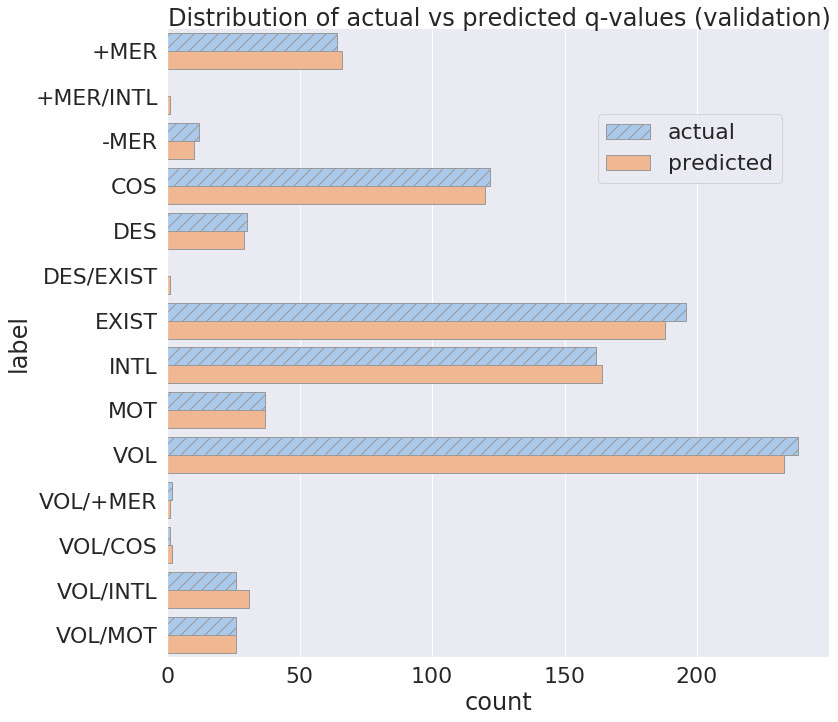

In [52]:
def plot_distribution_of_actual_vs_pred(ps, title):
    
    label = []
    split = []
    for p in ps:
        
        if len(p[1])==1:
            label.append(p[1][0])
            split.append('actual')
        elif len(p[1])==2:
            p_label = p[1]
            if 'VOL' in p_label[1]:
                p_label = list(reversed(p_label))
            label.append('/'.join(p_label))
            split.append('actual')

        
        if len(p[2])==1:
            label.append(p[2][0])
            split.append('predicted')
        elif len(p[2])==2:
            p_label = p[2]
            if 'VOL' in p_label[1]:
                p_label = list(reversed(p_label))
            label.append('/'.join(p_label))
            split.append('predicted')
        
        
    d = {'label':label, 'split':split}
    df_bar = pd.DataFrame(d)
    
    df_bar['label'] = df_bar['label'].astype("category")
    
    #ax = sns.countplot(x="split", hue="label", data=df_bar)
    
    #plt.figure(figsize=(30, 10))
    sns.set(rc={'figure.figsize':(25.7,16.27)}, font_scale = 2)
        
    g = sns.catplot(y="label", hue="split", kind="count",
            palette="pastel", edgecolor=".6", height=10, aspect=1.2,
            data=df_bar, legend=False)
    
    n = len(pd.unique(df_bar['label'])) 
    
    bars = g.ax.patches
    pattern = ['//','']
    hatches = np.repeat(pattern, n)
    
    for pat,bar in zip(hatches,bars):
        bar.set_hatch(pat)
        
    g.fig.subplots_adjust(top=0.95)
    g.fig.suptitle(title, fontsize=24)
    
    #g.ax.legend(loc='lower right', bbox_to_anchor=(0.5, 1.1), ncol=3, fancybox=True, shadow=True)
    
    g.add_legend(bbox_to_anchor=(0.75, 0.85), loc=0, borderaxespad=0.2, frameon=True)
    
    #plt.show()
    
    if 'validation' in title:
        t = 'validation'
    else:
        t = 'test'
    
    g.savefig("/nfs/research/regan/viz/rq121-actual-vs-pred-dist-{}.pdf".format(t))
       
        
plot_distribution_of_actual_vs_pred(valid_preds, 'Distribution of actual vs predicted q-values (validation)')  
    

In [53]:
validation_logits = dict()
for p in valid_preds:
    actual = tuple(sorted(p[1]))
    lgts = p[3]
    if actual not in validation_logits:
        validation_logits[actual]=[]
    validation_logits[actual].append(lgts)
    


In [54]:
validation_logits.keys()

dict_keys([('COS',), ('INTL',), ('VOL',), ('INTL', 'VOL'), ('+MER',), ('EXIST',), ('MOT',), ('-MER',), ('MOT', 'VOL'), ('+MER', 'VOL'), ('DES',), ('COS', 'VOL')])

In [55]:
df_mot = pd.DataFrame(validation_logits[('MOT',)], columns=label_cols)
df_mot.head()

,+MER,-MER,COS,DES,EXIST,INTL,MOT,VOL
0,-4.741918,-4.847375,-4.902525,-4.791535,-4.687638,-4.717695,4.350996,-4.680542
1,-5.072668,-5.090654,-4.552690,-4.613734,-4.669158,-5.059896,4.627715,-4.008126
2,-5.130495,-5.124321,-4.515291,-4.650173,-4.660293,-4.988721,4.545057,-4.152697
3,-5.128482,-5.050651,-4.429191,-4.536212,-4.616738,-4.999171,4.735441,-3.994770
4,-5.249374,-5.381987,4.852865,-5.233031,-5.361565,-5.296515,-4.854260,-5.367704


In [56]:
df_mot['+MER'].mean()

-4.726468530861107

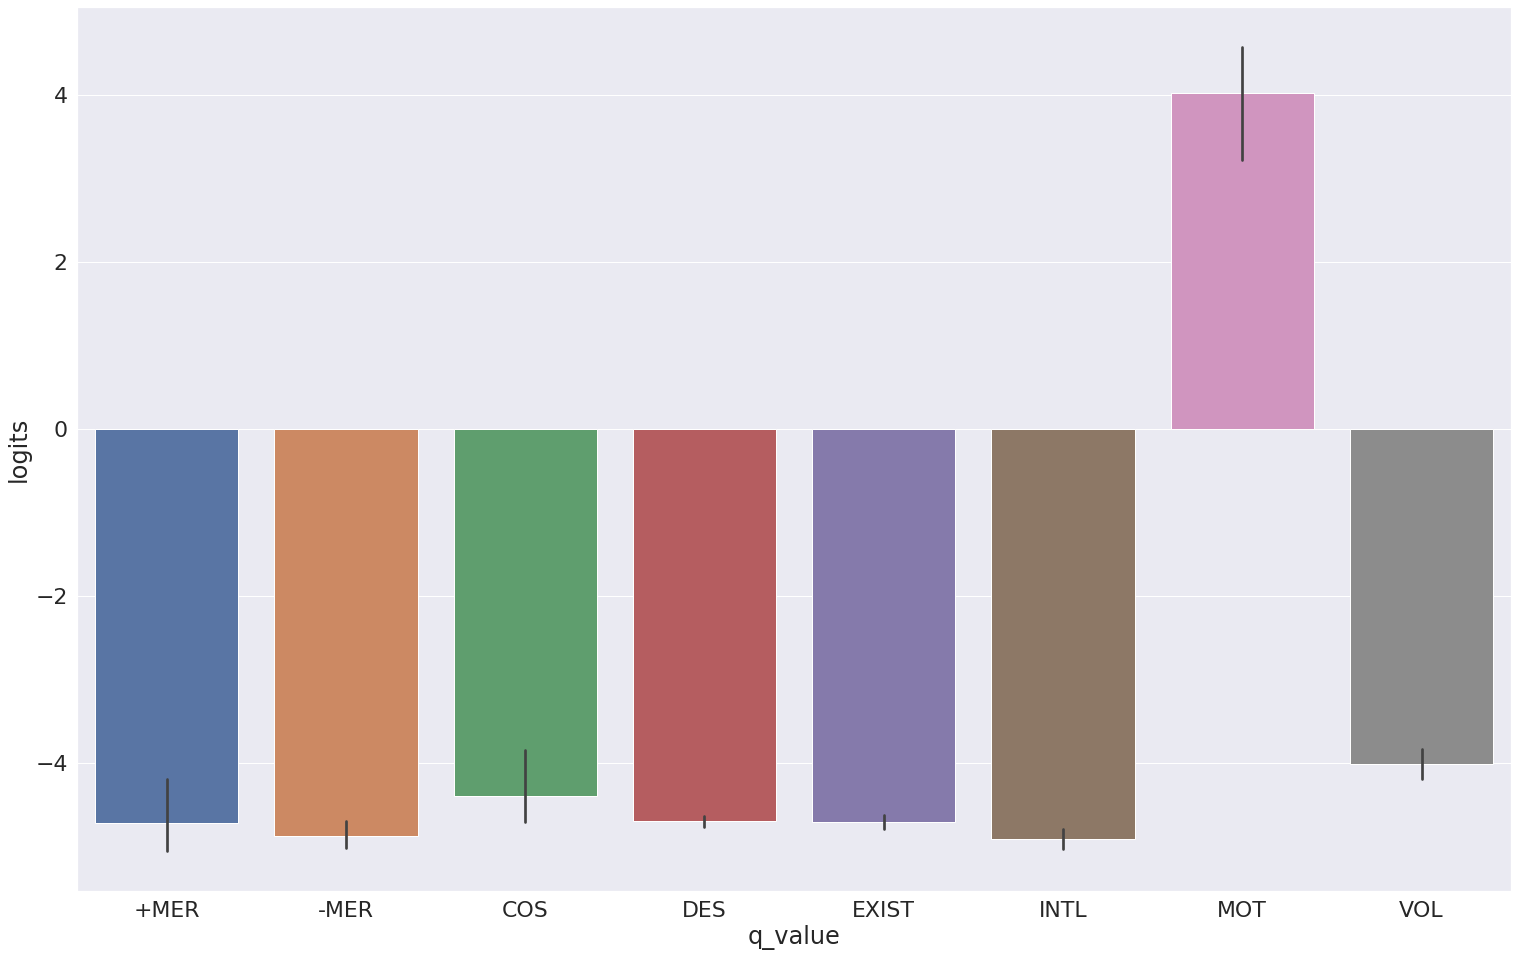

In [57]:
bar_plots_validation = {}

for p in valid_preds:
    actual = tuple(sorted(p[1]))
    lgts = p[3]
    
    if actual not in bar_plots_validation:
        bar_plots_validation[actual]={'q_values':[], 'logits':[]}
    for lc, lg in zip(label_cols, lgts):
        bar_plots_validation[actual]['q_values'].append(lc)
        bar_plots_validation[actual]['logits'].append(lg)

df_mot_1 = pd.DataFrame(
    {'q_value': bar_plots_validation[('MOT',)]['q_values'],
     'logits': bar_plots_validation[('MOT',)]['logits']
    })

ax = sns.barplot(x="q_value", y="logits", data=df_mot_1)

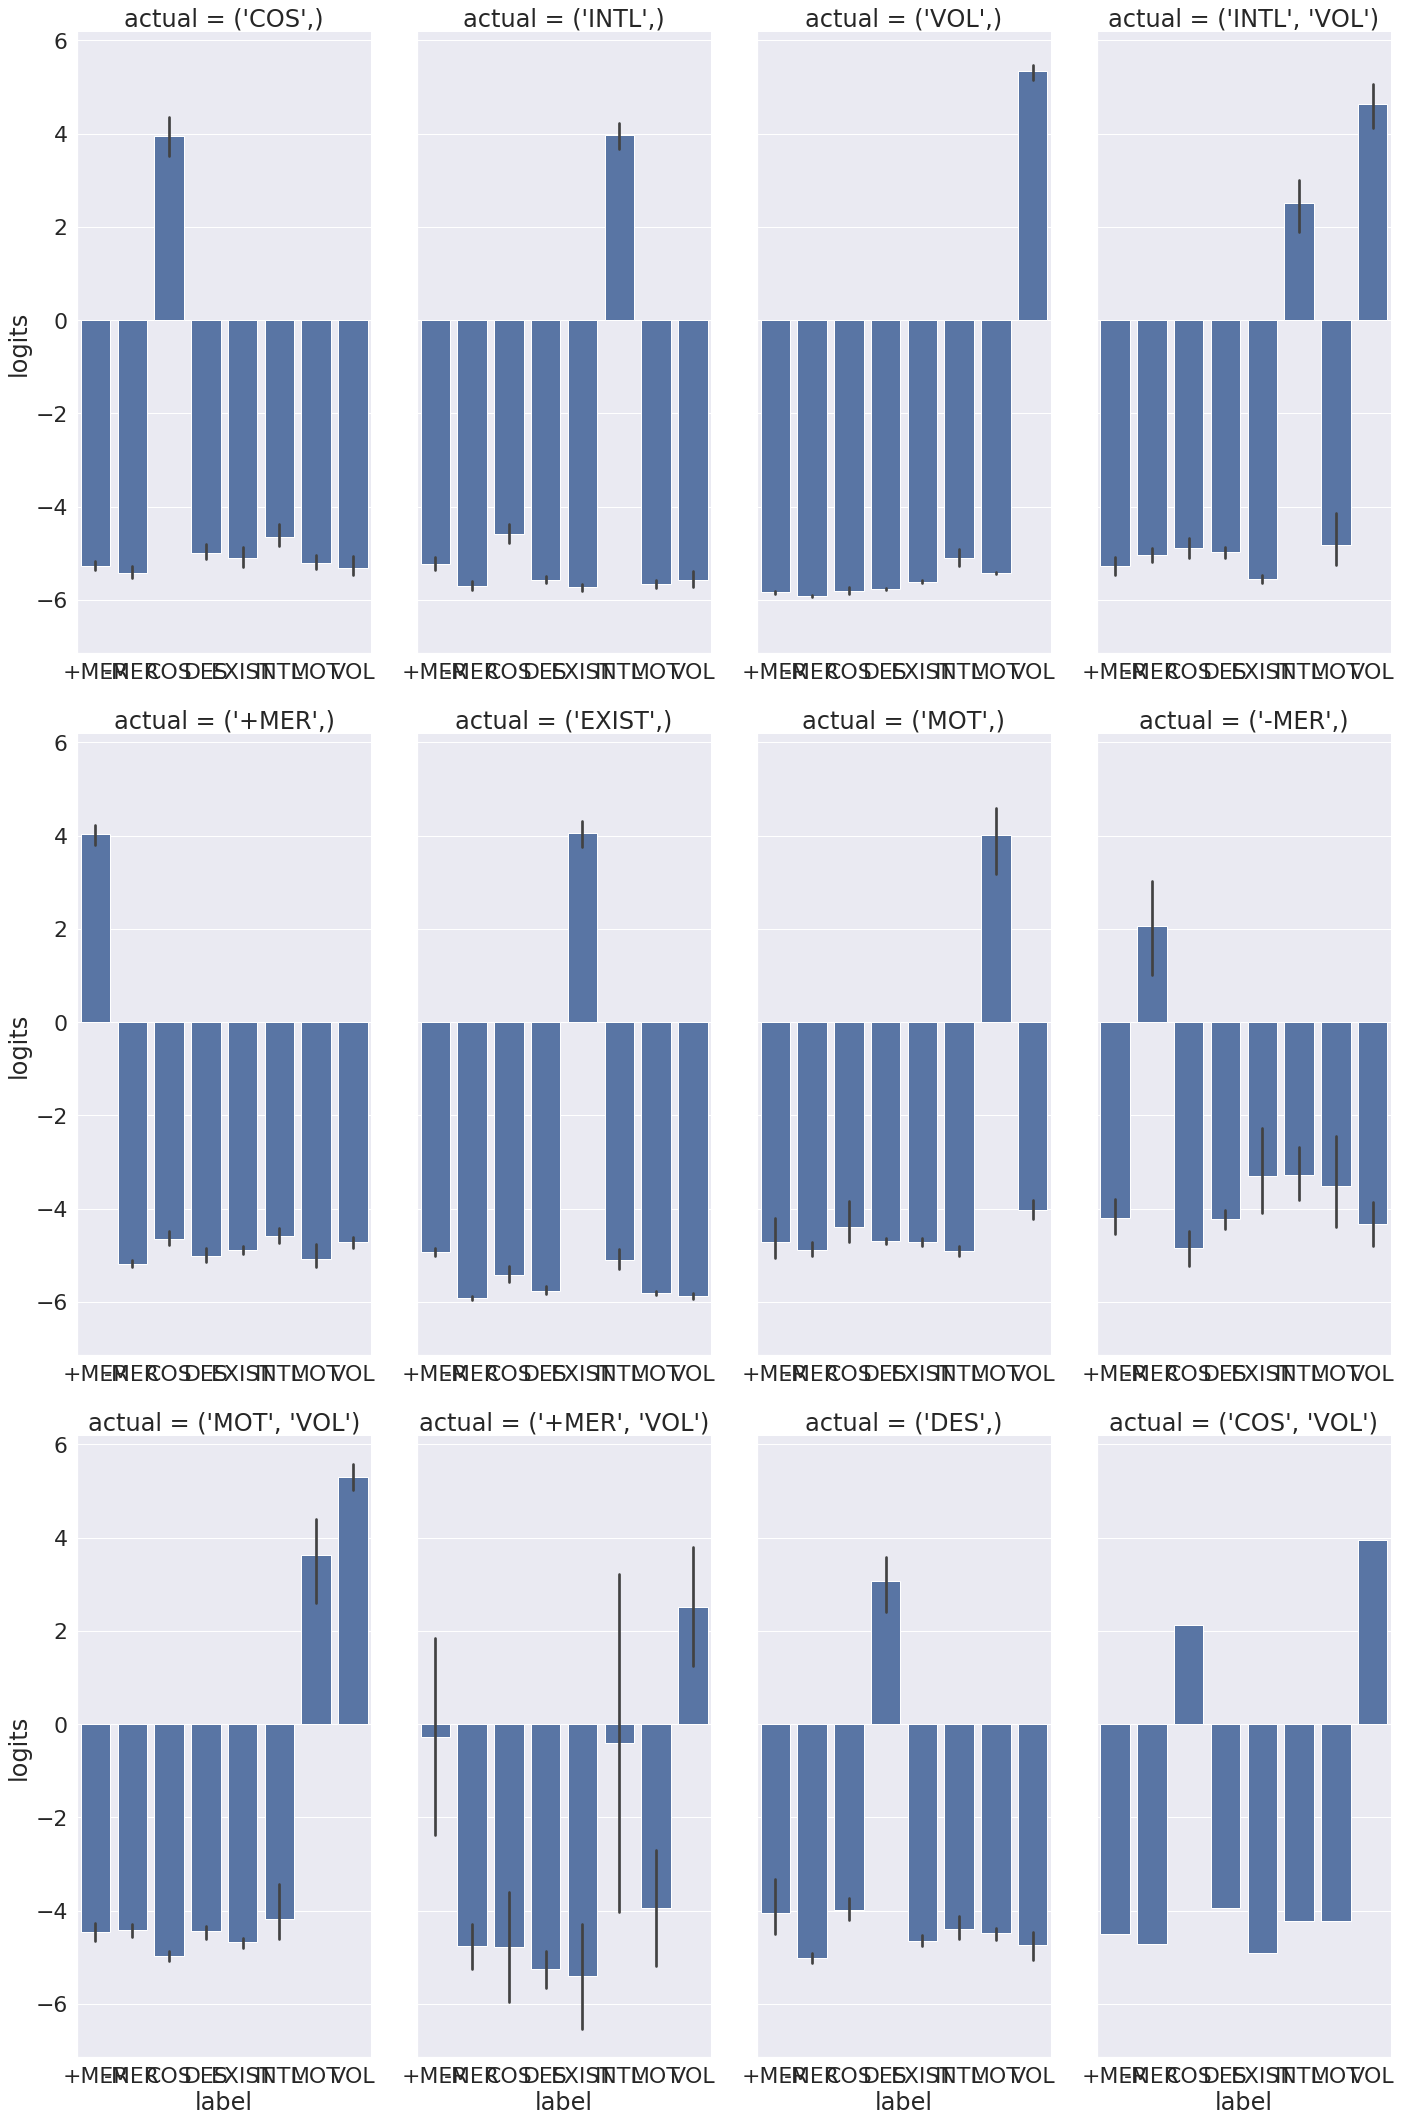

In [58]:
predicted = []
logits_plot = []
actuals = []

for p in valid_preds:
    actual = tuple(sorted(p[1]))
    lgts = p[3]
    
    for lc, lg in zip(label_cols, lgts):
        predicted.append(lc)
        logits_plot.append(lg)
        actuals.append(actual)

df_qvalue = pd.DataFrame(
    {'label': predicted,
     'logits': logits_plot,
     'actual': actuals
    })

df_qvalue.sort_values(by=['actual'])

g = sns.FacetGrid(df_qvalue, col="actual", col_wrap=4, height=10, aspect=.5)
g.map(sns.barplot, "label", "logits", order=label_cols)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
g.fig.tight_layout()

#g.savefig("/nfs/research/regan/viz/rq121_facet_plot.eps")


In [59]:
label_cols_for_stacked_plot = label_cols + ['None']

data = []
for lab in label_cols:
    d = [lab] + [0]*len(label_cols_for_stacked_plot)
    data.append(d)

for p in valid_preds:
    y_trues = sorted(p[1])
    # just getting the first one; getting both labels is harder to account for
    idx = label_cols.index(y_trues[0])
    if len(p[2])>0:
        pred_idx = label_cols_for_stacked_plot.index(p[2][0])+1
    else:
        pred_idx = label_cols_for_stacked_plot.index('None')+1
    data[idx][pred_idx]+=1
 
label_cols_for_stacked_plot.insert(0, 'q-value')
data

[['+MER', 64, 0, 0, 0, 0, 1, 1, 0, 0],
 ['-MER', 0, 10, 0, 0, 1, 0, 1, 0, 0],
 ['COS', 0, 0, 112, 1, 3, 4, 1, 0, 2],
 ['DES', 1, 0, 0, 28, 0, 0, 0, 0, 1],
 ['EXIST', 0, 0, 4, 1, 184, 5, 0, 0, 2],
 ['INTL', 2, 0, 4, 0, 0, 178, 1, 1, 2],
 ['MOT', 1, 0, 1, 0, 0, 1, 59, 1, 0],
 ['VOL', 0, 0, 1, 0, 0, 6, 0, 231, 0]]

In [60]:

df_train_bar = pd.DataFrame(data=data, columns=label_cols_for_stacked_plot)
df_train_bar


,q-value,+MER,-MER,COS,DES,EXIST,INTL,MOT,VOL,None
0,+MER,64,0,0,0,0,1,1,0,0
1,-MER,0,10,0,0,1,0,1,0,0
2,COS,0,0,112,1,3,4,1,0,2
3,DES,1,0,0,28,0,0,0,0,1
4,EXIST,0,0,4,1,184,5,0,0,2
5,INTL,2,0,4,0,0,178,1,1,2
6,MOT,1,0,1,0,0,1,59,1,0
7,VOL,0,0,1,0,0,6,0,231,0


In [61]:
def unknown_plot():

    ax = df_train_bar.set_index('q-value')\
      .reindex(df.set_index('q-value').sum().sort_values().index, axis=1)\
      .T.plot(kind='bar', stacked=True,
              colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
              figsize=(15,10),
              title='RQ 1.2.1 (validation): Actual with predicted q-values')
    ax.set_xlabel("Actual")

    # fig = ax.get_figure()
    # fig.savefig('/nfs/research/regan/rq121-stacked-bar-validation.eps')

In [62]:
#train, test = train_test_split(df1, test_size=0.0)
#train = df1.copy(deep=True)
test_df = df_test.copy(deep=True)
test_df.shape

#test = df_test.drop('property', axis=1)

(2702, 10)

In [63]:
test_label_cols = list(test_df.columns[1:9])
test_sentences = list(test_df.sentence.values)
#print(test_label_cols)
print('Null values: ', test_df.isnull().values.any()) #should not be any null sentences or labels
print('Same columns between train and test: ', label_cols == test_label_cols) #columns should be the same
test_df.head()

Null values:  False
Same columns between train and test:  True


,sentence,+MER,-MER,COS,DES,EXIST,INTL,MOT,VOL,property
0,<s> He listens impassively. </s> </s> He </s>,0,0,0,0,0,0,0,1,VOL
1,<s> They learned they could survive it without...,0,0,0,0,0,0,0,1,VOL
2,<s> President F.W. de Klerk released the ANC m...,0,0,0,0,0,0,0,1,VOL
3,"<s> She won grant money for the school, advise...",0,0,0,0,0,0,0,1,VOL
4,<s> Employees wore identification badges listi...,0,0,0,0,0,0,0,1,VOL


In [64]:
test_label_cols

['+MER', '-MER', 'COS', 'DES', 'EXIST', 'INTL', 'MOT', 'VOL']

In [65]:
label_cols

['+MER', '-MER', 'COS', 'DES', 'EXIST', 'INTL', 'MOT', 'VOL']

In [66]:
test_df['one_hot_labels'] = list(test_df[test_label_cols].values)
test_df.head()

,sentence,+MER,-MER,COS,DES,EXIST,INTL,MOT,VOL,property,one_hot_labels
0,<s> He listens impassively. </s> </s> He </s>,0,0,0,0,0,0,0,1,VOL,"[0, 0, 0, 0, 0, 0, 0, 1]"
1,<s> They learned they could survive it without...,0,0,0,0,0,0,0,1,VOL,"[0, 0, 0, 0, 0, 0, 0, 1]"
2,<s> President F.W. de Klerk released the ANC m...,0,0,0,0,0,0,0,1,VOL,"[0, 0, 0, 0, 0, 0, 0, 1]"
3,"<s> She won grant money for the school, advise...",0,0,0,0,0,0,0,1,VOL,"[0, 0, 0, 0, 0, 0, 0, 1]"
4,<s> Employees wore identification badges listi...,0,0,0,0,0,0,0,1,VOL,"[0, 0, 0, 0, 0, 0, 0, 1]"


In [67]:
# Gathering input data
test_labels = list(test_df.one_hot_labels.values)
test_comments = list(test_df.sentence.values)

In [68]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(test_comments,max_length=max_length,pad_to_max_length=True,return_token_type_ids=True)
test_input_ids = test_encodings['input_ids']
test_token_type_ids = test_encodings['token_type_ids']
test_attention_masks = test_encodings['attention_mask']

/nfs/research/regan/.conda/envs/torch-roberta/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [69]:
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
test_token_types = torch.tensor(test_token_type_ids)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels, test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

In [70]:
# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels, b_token_types = batch
  with torch.no_grad():
    # Forward pass
    outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    b_logit_pred = outs[0]
    pred_label = torch.sigmoid(b_logit_pred)

    b_logit_pred = b_logit_pred.detach().cpu().numpy()
    pred_label = pred_label.to('cpu').numpy()
    b_labels = b_labels.to('cpu').numpy()

  tokenized_texts.append(b_input_ids)
  logit_preds.append(b_logit_pred)
  true_labels.append(b_labels)
  pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
logit_preds = [item for sublist in logit_preds for item in sublist]
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

In [71]:
test_label_cols

['+MER', '-MER', 'COS', 'DES', 'EXIST', 'INTL', 'MOT', 'VOL']

In [72]:
true_labels[0:5]

[array([0, 0, 0, 0, 0, 0, 0, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 1])]

In [73]:
pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding
len(true_bools[0])

8

In [90]:
all_volitional_for_baseline = [true_labels[0]]*len(pred_bools)

len(all_volitional_for_baseline)

2702

In [91]:
all_volitional_for_baseline

array([0, 0, 0, 0, 0, 0, 0, 1])

In [74]:
len(pred_bools)

2702

In [93]:
# Print and save classification report
print('Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools,target_names=test_label_cols)
#pickle.dump(clf_report, open('../reports/classification_report_16_epochs_alltest.txt','wb')) #save report
print(clf_report)

Test F1 Accuracy:  0.6305084745762712
Test Flat Accuracy:  0.5854922279792746 

              precision    recall  f1-score   support

        +MER       0.34      0.58      0.43       153
        -MER       0.55      0.58      0.57        77
         COS       0.47      0.61      0.53       366
         DES       0.76      0.59      0.67       274
       EXIST       0.88      0.86      0.87       652
        INTL       0.64      0.46      0.53       684
         MOT       0.76      0.38      0.51       322
         VOL       0.71      0.67      0.69       239

   micro avg       0.66      0.60      0.63      2767
   macro avg       0.64      0.59      0.60      2767
weighted avg       0.69      0.60      0.63      2767
 samples avg       0.60      0.61      0.60      2767



/nfs/research/regan/.conda/envs/torch-roberta/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [94]:
# Baseline choose majority
print('Test F1 Accuracy: ', f1_score(true_bools, all_volitional_for_baseline,average='micro'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, all_volitional_for_baseline),'\n')
clf_report_baseline = classification_report(true_bools,all_volitional_for_baseline,target_names=test_label_cols)
print(clf_report_baseline)

Test F1 Accuracy:  0.08740171877857011
Test Flat Accuracy:  0.06439674315321983 

              precision    recall  f1-score   support

        +MER       0.00      0.00      0.00       153
        -MER       0.00      0.00      0.00        77
         COS       0.00      0.00      0.00       366
         DES       0.00      0.00      0.00       274
       EXIST       0.00      0.00      0.00       652
        INTL       0.00      0.00      0.00       684
         MOT       0.00      0.00      0.00       322
         VOL       0.09      1.00      0.16       239

   micro avg       0.09      0.09      0.09      2767
   macro avg       0.01      0.12      0.02      2767
weighted avg       0.01      0.09      0.01      2767
 samples avg       0.09      0.08      0.08      2767



In [76]:
vis_arr = multilabel_confusion_matrix(true_bools,pred_bools)
vis_arr

array([[[2378,  171],
        [  65,   88]],

       [[2588,   37],
        [  32,   45]],

       [[2078,  258],
        [ 141,  225]],

       [[2378,   50],
        [ 112,  162]],

       [[1976,   74],
        [  93,  559]],

       [[1841,  177],
        [ 372,  312]],

       [[2342,   38],
        [ 199,  123]],

       [[2399,   64],
        [  79,  160]]])

In [77]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

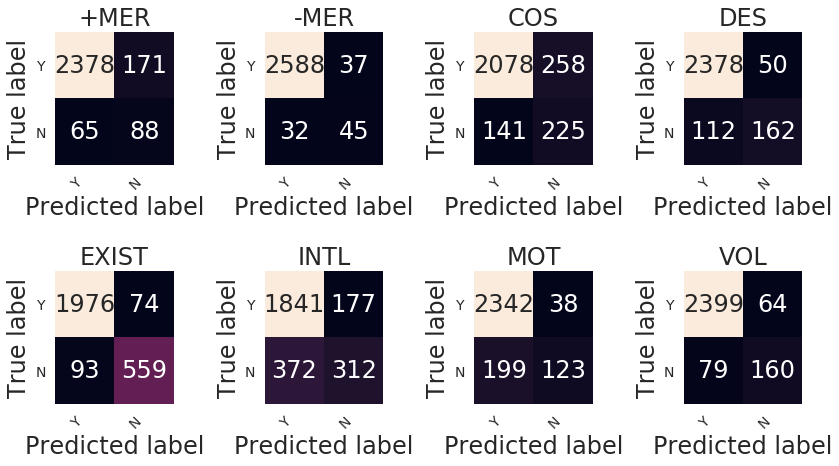

In [78]:
fig, ax = plt.subplots(2, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, test_label_cols):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])

fig.tight_layout()
plt.show()

In [79]:
all_preds =[(sent, get_q_values(label_cols,true.astype(bool)), get_q_values(label_cols,pred), logit) for (sent, true, pred, logit) in zip(test_sentences, true_labels, pred_bools, logit_preds)]



/nfs/research/regan/.conda/envs/torch-roberta/lib/python3.7/site-packages/seaborn/axisgrid.py:132: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  figlegend = self.fig.legend(handles, labels, **kwargs)


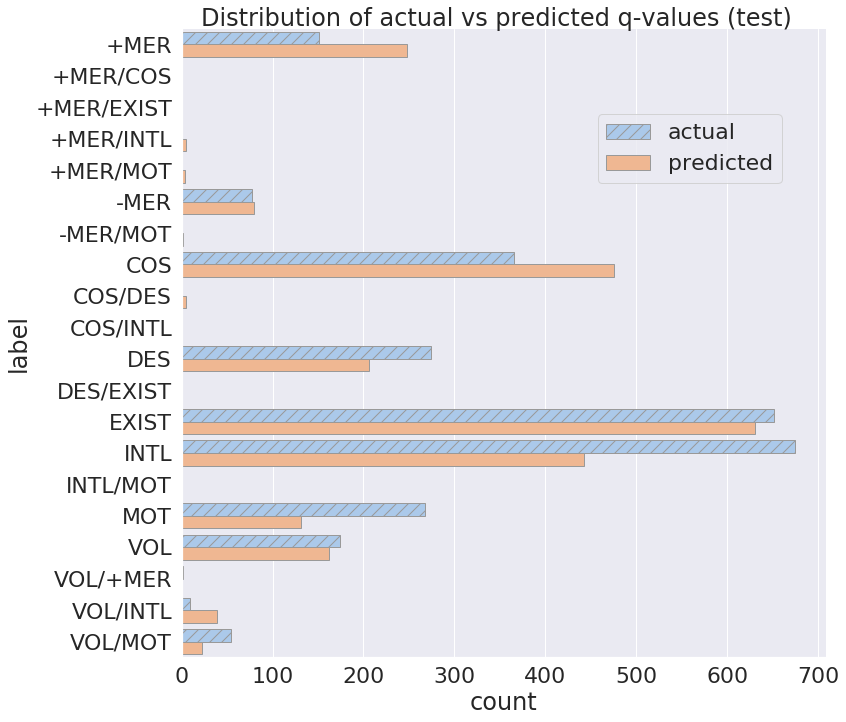

In [80]:
plot_distribution_of_actual_vs_pred(all_preds, 'Distribution of actual vs predicted q-values (test)')  

In [81]:
test_label_cols

['+MER', '-MER', 'COS', 'DES', 'EXIST', 'INTL', 'MOT', 'VOL']

In [82]:
for p in all_preds:
    print(p[0])
    print("Actual:", p[1])
    print("Pred:", p[2])
    print("Logits:", p[3])
    print()

<s> He listens impassively. </s> </s> He </s>
Actual: ['VOL']
Pred: ['INTL', 'VOL']
Logits: [-5.118304  -5.3807163 -4.998448  -5.5777583 -5.734923   2.1561966
 -5.5775347  4.369341 ]

<s> They learned they could survive it without much problem. '' </s> </s> They </s>
Actual: ['VOL']
Pred: ['INTL', 'VOL']
Logits: [-4.932561  -5.570785  -4.679905  -5.754515  -5.768576   1.22771
 -3.8502412  4.818335 ]

<s> President F.W. de Klerk released the ANC men--along with one of the founding members of the Pan Africanist Congress, a </s> </s> Klerk </s>
Actual: ['VOL']
Pred: []
Logits: [-5.577052   -6.430392   -5.94017    -7.010267   -5.8582125  -0.23965342
 -5.562536   -0.9777246 ]

<s> She won grant money for the school, advised cheerleaders, ran the pep club </s> </s> She </s>
Actual: ['VOL']
Pred: ['VOL']
Logits: [-5.708775  -5.7837853 -5.953976  -5.754992  -5.870905  -4.2035484
 -5.1718326  6.1074886]

<s> Employees wore identification badges listing not only their names but also their dates 

Logits: [-5.169788  -5.669805   5.017484  -5.1057515 -5.166777  -5.191922
 -5.1924887 -4.8213053]

<s> N.R. Mohanty stated that Hindustan Aeronautics Limited will also manufacture the 920 engines for the Sukhoi 30 MK fighter jets . </s> </s> engines </s>
Actual: ['DES']
Pred: ['COS']
Logits: [-4.888053  -6.4739285  1.0776013 -3.3041413 -6.1772814 -4.5234337
 -5.453464  -6.2484856]

<s> Hindustan Aeronautics Limited has paid a licence fee of 286 million United States dollars to Russia to be able to make the Sukhoi 30 MK fighter jets . </s> </s> Limited </s>
Actual: ['VOL']
Pred: []
Logits: [-4.3256927 -6.8681273 -5.3362727 -5.9586167 -2.6755826 -5.3759565
 -3.2527773 -6.0238514]

<s> Russian officials blamed the Indian governments's intransigence for the delay . </s> </s> officials </s>
Actual: ['VOL']
Pred: ['VOL']
Logits: [-5.7972884 -5.975449  -5.8880334 -5.8841367 -5.8253717 -5.013446
 -5.2210083  5.490692 ]

<s> neighboring Kyrgyzstan has also experienced raids by Taliban-backed Is

Pred: ['EXIST']
Logits: [-3.5020242  -5.8751674  -6.1755967  -6.177629    0.41510534 -0.6284931
 -6.7035756  -7.156885  ]

<s> Pressure caused by sedimentary rocks squeezes water out of peat </s> </s> water </s>
Actual: ['-MER']
Pred: ['-MER']
Logits: [-4.4831753  2.8086295 -5.0103383 -3.7738326 -2.1686537 -3.7581608
 -3.839462  -4.312801 ]

<s> Pressure caused by sedimentary rocks squeezes water out of peat </s> </s> peat </s>
Actual: ['EXIST']
Pred: ['EXIST']
Logits: [-4.552157  -5.5579567 -4.865124  -6.156041   3.505531  -5.580759
 -6.22691   -6.277092 ]

<s> Heat changes material into coal </s> </s> Heat </s>
Actual: ['INTL']
Pred: ['EXIST']
Logits: [-3.3705077 -6.7271943 -5.4468746 -6.559912   1.2455094 -3.571531
 -6.920802  -6.3305492]

<s> Heat changes material into coal </s> </s> material </s>
Actual: ['COS']
Pred: ['COS']
Logits: [-5.4635115 -5.4247923  4.691226  -5.153117  -5.11802   -5.1694517
 -5.3239894 -5.4068127]

<s> There is lot of rain </s> </s> rain </s>
Actual: ['IN

Logits: [-4.88508   -5.6152873 -4.4613256 -5.5508943 -5.1709113  4.143631
 -5.67188   -6.0329876]

<s> Chemical reactions break down bonds holding rocks together </s> </s> reactions </s>
Actual: ['INTL']
Pred: ['INTL']
Logits: [-5.0160937 -6.5136304 -5.0091696 -6.252119  -3.167868   2.2422004
 -6.988482  -6.435917 ]

<s> Chemical reactions break down bonds holding rocks together </s> </s> bonds </s>
Actual: ['COS']
Pred: []
Logits: [-5.3529463  -2.1426654  -2.0846496  -5.510208   -4.409088   -0.44332832
 -6.4742184  -6.3472786 ]

<s> rocks fall apart </s> </s> rocks </s>
Actual: ['COS']
Pred: ['COS']
Logits: [-5.8454947 -5.799283   4.310043  -5.0143013 -5.29952   -4.271484
 -5.7153964 -5.681076 ]

<s> They form smaller and smaller pieces </s> </s> They </s>
Actual: ['INTL']
Pred: ['VOL']
Logits: [-6.1448126 -5.9215207 -5.746348  -5.6820765 -5.7257614 -5.0525727
 -5.5068083  5.5781093]

<s> They form smaller and smaller pieces </s> </s> pieces </s>
Actual: ['DES']
Pred: ['DES']
Logits: 

 -6.828769   -7.281048  ]

<s> heart moves blood throughout body </s> </s> heart </s>
Actual: ['INTL']
Pred: ['INTL']
Logits: [-5.606101  -5.876716  -5.191248  -6.03212   -6.1254916  4.3161373
 -5.8518224 -4.793682 ]

<s> heart moves blood throughout body </s> </s> blood </s>
Actual: ['MOT']
Pred: ['MOT']
Logits: [-1.5561208 -3.3798177 -5.250294  -4.8512917 -4.915997  -6.0714006
  1.3173023 -5.803809 ]

<s> heart moves blood throughout body </s> </s> body </s>
Actual: ['EXIST']
Pred: ['EXIST']
Logits: [-5.113367  -5.9926405 -5.53192   -5.935946   4.533487  -5.593848
 -5.6486893 -5.950553 ]

<s> virus finds animal cell </s> </s> virus </s>
Actual: ['COS']
Pred: ['INTL']
Logits: [-2.091139  -5.6820865 -5.4019675 -6.081268  -6.2619653  2.5901952
 -5.5243144 -6.254671 ]

<s> virus finds animal cell </s> </s> cell </s>
Actual: ['EXIST']
Pred: ['EXIST']
Logits: [-4.734268  -6.0558796 -5.199437  -5.8390746  4.4988256 -5.145551
 -5.9168944 -6.3576984]

<s> virus attaches to cell 's surface </s

 -6.0269947 -5.8401604]

<s> Pour water on seed and hold </s> </s> water </s>
Actual: ['+MER']
Pred: ['+MER']
Logits: [ 4.403419  -5.333736  -4.8906717 -5.0974298 -4.685477  -4.402551
 -5.4423833 -4.716558 ]

<s> Pour water on seed and hold </s> </s> seed </s>
Actual: ['EXIST']
Pred: ['EXIST']
Logits: [-4.159079  -6.0300336 -5.8833785 -6.178984   4.1779    -5.4323835
 -5.803564  -5.95953  ]

<s> Cover up hole </s> </s> hole </s>
Actual: ['+MER']
Pred: ['COS']
Logits: [-4.854342  -5.6617107  4.3760104 -4.716335  -6.0933733 -3.992304
 -5.549933  -5.6552324]

<s> Press down on it </s> </s> it </s>
Actual: ['EXIST']
Pred: ['EXIST']
Logits: [-4.189096  -6.230973  -4.2283754 -5.8751044  3.442767  -5.2681026
 -6.066831  -6.9730935]

<s> You plant vegetable seeds in ground </s> </s> You </s>
Actual: ['VOL']
Pred: ['VOL']
Logits: [-5.803968  -5.999026  -6.03698   -5.8339157 -5.6523333 -5.370628
 -5.4902625  5.335225 ]

<s> You plant vegetable seeds in ground </s> </s> seeds </s>
Actual: ['+MER'

 -6.0443144 -6.701418 ]

<s> Someone turns car on with key </s> </s> key </s>
Actual: ['INTL']
Pred: ['INTL']
Logits: [-5.4658785 -5.8303447 -5.0801926 -5.7664537 -5.767828   4.6689196
 -5.6784725 -5.6755304]

<s> car 's battery produces a spark of electricity </s> </s> battery </s>
Actual: ['INTL']
Pred: ['INTL']
Logits: [-5.1984687 -5.917274  -4.9327035 -5.9845843 -5.5734763  4.139065
 -6.1231904 -5.9175925]

<s> car 's battery produces a spark of electricity </s> </s> spark </s>
Actual: ['DES']
Pred: ['DES']
Logits: [-5.1698346 -5.311089  -5.6435056  0.9354782 -3.2606242 -1.4909807
 -5.071752  -5.9979153]

<s> spark ignites gas </s> </s> spark </s>
Actual: ['INTL']
Pred: ['INTL']
Logits: [-5.1071744 -6.1265244 -5.0743566 -5.906805  -4.6394863  3.8263664
 -6.1894336 -6.370534 ]

<s> spark ignites gas </s> </s> gas </s>
Actual: ['COS']
Pred: ['EXIST']
Logits: [-3.7190835 -5.976777  -3.548956  -3.4030263  0.8219775 -4.3957806
 -6.29597   -8.367668 ]

<s> burning gas expands when it enc

Logits: [-3.9795673 -4.606379  -5.09125    2.1783438 -5.076473  -3.8537698
 -4.425206  -5.315356 ]

<s> pancreas releases enzymes to aid digestion </s> </s> aid </s>
Actual: ['EXIST']
Pred: ['EXIST']
Logits: [-4.9401226 -5.927023  -5.0630474 -4.4625506  3.134599  -4.6059427
 -6.1492043 -7.0267754]

<s> Digested food affects amount of sugar in blood </s> </s> food </s>
Actual: ['INTL']
Pred: []
Logits: [-0.5062463  -5.4083896  -3.5054607  -6.086744   -3.327683   -0.99161917
 -6.315204   -8.089738  ]

<s> Digested food affects amount of sugar in blood </s> </s> amount </s>
Actual: ['COS']
Pred: []
Logits: [-1.7305105 -4.550134  -5.144199  -4.8792543 -0.7868239 -2.9445696
 -5.760314  -8.042848 ]

<s> pancreas releases one hormone to lower blood sugar glucose level </s> </s> pancreas </s>
Actual: ['INTL']
Pred: ['VOL']
Logits: [-6.073323  -6.488273  -6.043552  -6.535423  -5.593241  -4.155698
 -6.563342   3.2093127]

<s> pancreas releases one hormone to lower blood sugar glucose level </s> 

In [83]:
for p in all_preds:
    
    if 'COS' in p[2] and 'INTL' in p[2]:
        print(p[0])
        print("Actual:", p[1])
        print("Pred:", p[2])
        print("Logits:", p[3])
        print()

<s> 300 millions years ago plants and trees died </s> </s> plants </s>
Actual: ['COS']
Pred: ['COS', 'INTL']
Logits: [-6.0504923  -5.415801    0.5788519  -5.3544173  -5.6357293   0.10746358
 -5.9653916  -6.645942  ]



In [84]:
test_grouped_input = {}
done = []

for p in all_preds:
    s = re.findall(r'<s> (.*) </s> </s>.*</s>', p[0])[0]
    if s not in test_grouped_input:
        test_grouped_input[s]=[]
    actual_pred = (p[0], p[1], p[2], nlargest(3, softmax(p[3])))
    
    test_grouped_input[s].append(actual_pred)
    
for k, v in test_grouped_input.items():
    #print(k)
    for i in v:
        if i[1]!=i[2] and len(v)>1:
            if k not in done:
                done.append(k)
                print(k)
                for ii in v:
                    print(ii)
                print()


Employees wore identification badges listing not only their names but also their dates of hire.
('<s> Employees wore identification badges listing not only their names but also their dates of hire. </s> </s> Employees </s>', ['VOL'], ['VOL'], [0.99957716, 0.00033530398, 3.6109923e-05])
('<s> Employees wore identification badges listing not only their names but also their dates of hire. </s> </s> badges </s>', ['EXIST'], [], [0.55798286, 0.25531814, 0.09889931])

He produced it.
('<s> He produced it. </s> </s> He </s>', ['VOL'], ['VOL'], [0.99989605, 2.4431192e-05, 1.6292695e-05])
('<s> He produced it. </s> </s> it </s>', ['DES'], ['INTL'], [0.98643786, 0.011257195, 0.00086586364])

Cap added four more divisions to the Army, two active and two reserve ; two carrier groups to the Navy ; a
('<s> Cap added four more divisions to the Army, two active and two reserve ; two carrier groups to the Navy ; a </s> </s> Cap </s>', ['VOL'], [], [0.5552583, 0.3943118, 0.025128039])
('<s> Cap added fo

('<s> Light passes to iris </s> </s> Light </s>', ['MOT'], ['+MER'], [0.9937715, 0.0038703843, 0.00075563573])
('<s> Light passes to iris </s> </s> iris </s>', ['EXIST'], ['EXIST'], [0.99966013, 0.00011088716, 5.9046433e-05])

retina converts light that reaches retina into electric signal
('<s> retina converts light that reaches retina into electric signal </s> </s> retina </s>', ['INTL'], [], [0.7151524, 0.15498649, 0.11184621])
('<s> retina converts light that reaches retina into electric signal </s> </s> light </s>', ['COS'], ['+MER'], [0.95190734, 0.02611821, 0.0071875444])

Sends signal to brain
('<s> Sends signal to brain </s> </s> signal </s>', ['+MER'], ['MOT'], [0.9897629, 0.00787682, 0.00058777013])
('<s> Sends signal to brain </s> </s> brain </s>', ['EXIST'], ['EXIST'], [0.9997349, 6.864454e-05, 4.871282e-05])

brain translates electrical signals into images person sees
('<s> brain translates electrical signals into images person sees </s> </s> brain </s>', ['INTL'], ['VOL']

In [85]:
label_cols_for_stacked_plot = test_label_cols + ['None']

data = []
for lab in test_label_cols:
    d = [lab] + [0]*len(label_cols_for_stacked_plot)
    data.append(d)

for p in all_preds:
    y_trues = sorted(p[1])
    # just getting the first one; getting both labels is harder to account for
    idx = test_label_cols.index(y_trues[0])
    if len(p[2])>0:
        
        pred_idx = label_cols_for_stacked_plot.index(p[2][0])+1
    else:
        pred_idx = label_cols_for_stacked_plot.index('None')+1
    data[idx][pred_idx]+=1
 
label_cols_for_stacked_plot.insert(0, 'q-value')
data

[['+MER', 88, 4, 2, 7, 3, 12, 23, 2, 12],
 ['-MER', 2, 45, 1, 4, 1, 8, 5, 0, 11],
 ['COS', 19, 15, 225, 15, 10, 45, 1, 0, 36],
 ['DES', 7, 0, 59, 157, 7, 13, 0, 2, 29],
 ['EXIST', 11, 3, 6, 8, 557, 35, 3, 0, 29],
 ['INTL', 39, 2, 175, 11, 36, 310, 4, 43, 64],
 ['MOT', 93, 13, 9, 5, 12, 29, 117, 10, 34],
 ['VOL', 0, 0, 5, 0, 5, 31, 1, 105, 27]]

In [86]:

df_test_bar = pd.DataFrame(data=data, columns=label_cols_for_stacked_plot)
df_test_bar

,q-value,+MER,-MER,COS,DES,EXIST,INTL,MOT,VOL,None
0,+MER,88,4,2,7,3,12,23,2,12
1,-MER,2,45,1,4,1,8,5,0,11
2,COS,19,15,225,15,10,45,1,0,36
3,DES,7,0,59,157,7,13,0,2,29
4,EXIST,11,3,6,8,557,35,3,0,29
5,INTL,39,2,175,11,36,310,4,43,64
6,MOT,93,13,9,5,12,29,117,10,34
7,VOL,0,0,5,0,5,31,1,105,27


In [87]:
ax = df_test_bar.set_index('q-value')\
  .reindex(df.set_index('q-value').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(15,10),
          title='RQ 1.2.1 (test): Actual with predicted q-values')
ax.set_xlabel("Actual")

# fig = ax.get_figure()
# fig.savefig('/nfs/research/regan/rq121-stacked-bar-test.eps')

KeyError: "None of ['q-value'] are in the columns"

In [ ]:
predicted = []
logits_plot = []
actuals = []

for p in all_preds:
    actual = tuple(sorted(p[1]))
    lgts = p[3]
    
    for lc, lg in zip(label_cols, lgts):
        predicted.append(lc)
        logits_plot.append(lg)
        actuals.append(actual)

df_qvalue = pd.DataFrame(
    {'label': predicted,
     'logits': logits_plot,
     'actual': actuals
    })

df_qvalue.sort_values(by=['actual'])

g = sns.FacetGrid(df_qvalue, col="actual", col_wrap=4, height=10, aspect=.5)
g.map(sns.barplot, "label", "logits", order=label_cols)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
g.fig.tight_layout()

#g.savefig("/nfs/research/regan/viz/rq121_facet_plot_test.eps")